# __Porting STATUS__: Successful

First importing as always

In [15]:
#from google.colab import drive
import sys
from os.path import join
import os

ROOT = '/home/ashar'     # default for the drive
DATASET = 'dataset/trainset'       # path to your dataset on Drive

DATASET_PATH = join(ROOT, DATASET)

# now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('{}'.format(DATASET_PATH))

print(sys.path)

os.chdir(DATASET_PATH)    # Changing directory so we can load json files
!ls

['/home/ashar/LaneNet/data', '/opt/anaconda3/lib/python37.zip', '/opt/anaconda3/lib/python3.7', '/opt/anaconda3/lib/python3.7/lib-dynload', '', '/opt/anaconda3/lib/python3.7/site-packages', '/opt/anaconda3/lib/python3.7/site-packages/IPython/extensions', '/home/ashar/.ipython', '/home/ashar/dataset/trainset', '/home/ashar/dataset/trainset', '/home/ashar/dataset/trainset']
clips		      label_data_0531.json  readme.md
label_data_0313.json  label_data_0601.json


In [16]:
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt
#from evaluate.lane import LaneEval
%matplotlib inline

Suppose we have two json files, one is the ground truth and the other is the prediction.

We assume that each line in prediction json file is corresponding to the ground truth json, 
which means both lines are related to the same image.

In [17]:
json_pred = [json.loads(line) for line in open('label_data_0313.json').readlines()]
json_gt = [json.loads(line) for line in open('label_data_0313.json')]

In [18]:
pred, gt = json_pred[1], json_gt[1]
pred_lanes = pred['lanes']
#run_time = pred['run_time']
gt_lanes = gt['lanes']
y_samples = gt['h_samples']
raw_file = gt['raw_file']

First let's check out the image.

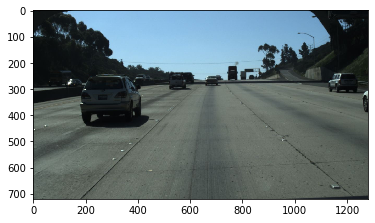

In [19]:
img = plt.imread(raw_file)
plt.imshow(img)
plt.show()

Then, we show how to use `y_samples`.

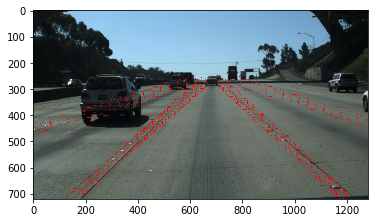

In [20]:
gt_lanes_vis = [[(x, y) for (x, y) in zip(lane, y_samples) if x >= 0] for lane in gt_lanes]
img_vis = img.copy()

for lane in gt_lanes_vis:
    for pt in lane:
        cv2.circle(img_vis, pt, radius=20, color=(255, 0, 0))

plt.imshow(img_vis)
plt.show()

Then, we show the ground truth and the prediction example.

The ground truth is shown in green and the prediction is shown in blue. As we can see the prediction is not perfect.

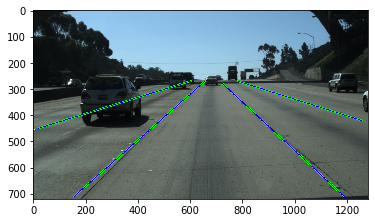

In [21]:
gt_lanes_vis = [[(x, y) for (x, y) in zip(lane, y_samples) if x >= 0] for lane in gt_lanes]
pred_lanes_vis = [[(x, y) for (x, y) in zip(lane, y_samples) if x >= 0] for lane in pred_lanes]
img_vis = img.copy()

for lane in gt_lanes_vis:
    cv2.polylines(img_vis, np.int32([lane]), isClosed=False, color=(0,255,0), thickness=5)
for lane in pred_lanes_vis:
    cv2.polylines(img_vis, np.int32([lane]), isClosed=False, color=(0,0,255), thickness=2)

plt.imshow(img_vis)
plt.show()

Now we can use the tool to evaluate the prediction based on the data.

The evaluation metric is described on the benchmark website.

In [22]:
#np.random.shuffle(pred_lanes)
# Overall Accuracy, False Positive Rate, False Negative Rate
#print LaneEval.bench(pred_lanes, gt_lanes, y_samples, run_time)

# Generating an image mask for lanes


In [23]:
json_gt = [json.loads(line) for line in open('label_data_0601.json')]
raw_image = "clips/seg_label/0601/1494453521596643824/20.png"
img = plt.imread(raw_image)
plt.imshow(img)
plt.show()

# Not happy with the result generated 

FileNotFoundError: [Errno 2] No such file or directory: 'clips/seg_label/0601/1494453521596643824/20.png'

Let's try it ourselves

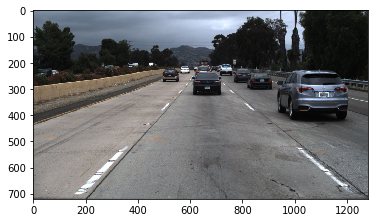

In [24]:
gt = json_gt[4]
raw_image = gt['raw_file']
img = plt.imread(raw_image)
plt.imshow(img)
plt.show()

[[(476, 270), (447, 280), (418, 290), (389, 300), (360, 310), (331, 320), (301, 330), (272, 340), (243, 350), (214, 360), (185, 370), (156, 380), (127, 390), (97, 400), (68, 410), (39, 420), (10, 430)], [(613, 260), (603, 270), (592, 280), (582, 290), (572, 300), (561, 310), (551, 320), (541, 330), (531, 340), (520, 350), (510, 360), (500, 370), (489, 380), (479, 390), (469, 400), (459, 410), (448, 420), (438, 430), (428, 440), (417, 450), (407, 460), (397, 470), (387, 480), (376, 490), (366, 500), (356, 510), (345, 520), (335, 530), (325, 540), (315, 550), (304, 560), (294, 570), (284, 580), (273, 590), (263, 600), (253, 610), (243, 620), (232, 630), (222, 640), (212, 650), (201, 660), (191, 670), (181, 680), (170, 690), (160, 700), (150, 710)], [(713, 270), (725, 280), (737, 290), (749, 300), (761, 310), (774, 320), (786, 330), (798, 340), (810, 350), (822, 360), (834, 370), (846, 380), (858, 390), (870, 400), (882, 410), (894, 420), (906, 430), (918, 440), (930, 450), (942, 460), (9

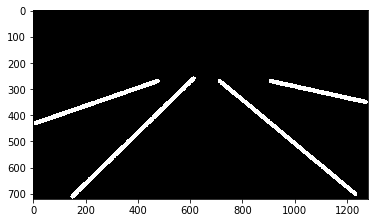

In [25]:
# ---------- clean and sort lanes -------------
label = gt
lanes = []
_lanes = []
slope = [] # identify 1st, 2nd, 3rd, 4th lane through slope
for i in range(len(label['lanes'])):
    l = [(x, y) for x, y in zip(label['lanes'][i], label['h_samples']) if x >= 0]
    if (len(l)>1):
        _lanes.append(l)
        slope.append(np.arctan2(l[-1][1]-l[0][1], l[0][0]-l[-1][0]) / np.pi * 180)
_lanes = [_lanes[i] for i in np.argsort(slope)]
slope = [slope[i] for i in np.argsort(slope)]

idx_1 = None
idx_2 = None
idx_3 = None
idx_4 = None
for i in range(len(slope)):
    if slope[i]<=90:
        idx_2 = i
        idx_1 = i-1 if i>0 else None
    else:
        idx_3 = i
        idx_4 = i+1 if i+1 < len(slope) else None
        break
lanes.append([] if idx_1 is None else _lanes[idx_1])
lanes.append([] if idx_2 is None else _lanes[idx_2])
lanes.append([] if idx_3 is None else _lanes[idx_3])
lanes.append([] if idx_4 is None else _lanes[idx_4])
print(lanes)
# ---------------------------------------------

H, W = 720, 1280
SEG_WIDTH = 30
seg_img = np.zeros((H, W, 3))
list_str = []  # str to be written to list.txt
for i in range(4):
  coords = lanes[i]
  if len(coords) < 4:
      continue
  for j in range(len(coords)-1):
      ################ THE ISSUE WAS THE COLOR HERE
      cv2.line(seg_img, coords[j], coords[j+1], (255, 255, 255), SEG_WIDTH//2)
      ################ THE ISSUE WAS THE COLOR HERE
  list_str.append('1')
 
cv2.imwrite('img.png', seg_img)
img = plt.imread('img.png')
plt.imshow(img)
plt.show()